
# Warm-up exercises with denoising autoencoders.

This notebook contains the first exercise for the NORA research summer school on self-supervised learning. The exercise in this notebook is pre-training a simple neural network using a denoising autoencoder approach and fine-tuning the network for classification.

The notebook is seperated into several segments with both complete code and code with missing components. Your job is to fill in the missing component.


Remember to enable GPU processing: edit->notebook settings -> hardware accelerator -> GPU.


In [ ]:
#@title Code block for importing packages

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans




#Creating the data

The following code-block creates and plots the data used in the notebook. We will use the simple ["two moons"-dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html), where the task is to classify two-dimensional data into two classes. Six data arrays are created:

x_tr_l: 10 training samples with labels.
y_tr_l: labels of y_tr_l

x_tr_ul: 100 training samples without labels used for pre-training.
y_tr_ul: labels of x_tr_ul (only used for plotting.

x_te: 500 testing samples with labels
y_te: labels of x_te

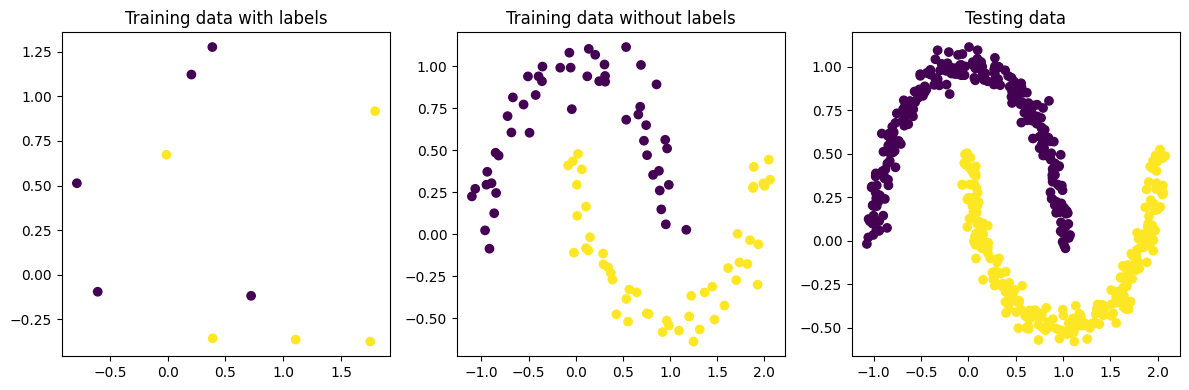

In [ ]:
#@title Code block for creating dataset

device = 'cpu'

x_tr_l, y_tr_l = make_moons(n_samples=10, random_state=6, noise=0.2)
x_tr_ul, y_tr_ul = make_moons(n_samples=100, random_state=0, noise=0.1)
x_te, y_te = make_moons(n_samples=500, noise=0.05)

plt.figure(1, figsize=(12, 4))
plt.subplot(131)
plt.scatter(x_tr_l[:, 0], x_tr_l[:, 1], c=y_tr_l)
plt.title('Training data with labels')
plt.subplot(132)
plt.scatter(x_tr_ul[:, 0], x_tr_ul[:, 1], c=y_tr_ul)
plt.title('Training data without labels')
plt.subplot(133)
plt.scatter(x_te[:, 0], x_te[:, 1], c=y_te)
plt.title('Testing data')
plt.tight_layout()
plt.show()

x_tr_l = torch.tensor(x_tr_l, dtype=torch.float, device=device)
y_tr_l = torch.tensor(y_tr_l, dtype=torch.long, device=device)
x_tr_ul = torch.tensor(x_tr_ul, dtype=torch.float, device=device)
y_tr_ul = torch.tensor(y_tr_ul, dtype=torch.long, device=device)
x_te = torch.tensor(x_te, dtype=torch.float, device=device)
y_te = torch.tensor(y_te, dtype=torch.long, device=device)

In [ ]:
#@title creating classification network and autoencoder network.


class classifier(nn.Module):
    def __init__(self, num_classes):
        super(classifier, self).__init__()

        n_hid = 10
        act = nn.ReLU()

        self.encoder = nn.Sequential(
                nn.Linear(2, n_hid),
                nn.ReLU(),
                nn.Linear(n_hid, n_hid),
                nn.ReLU())

        self.classification_head = nn.Sequential(
                nn.Linear(n_hid, num_classes))

    def forward(self, x):

      encoder_out = self.encoder(x)
      predictions = self.classification_head(encoder_out)

      return predictions, encoder_out


class ss_network(nn.Module):
    def __init__(self):
        super(ss_network, self).__init__()

        n_hid = 10
        act = nn.ReLU()

        self.encoder = nn.Sequential(
                nn.Linear(2, n_hid),
                nn.ReLU(),
                nn.Linear(n_hid, n_hid),
                nn.ReLU())

        self.decoder = nn.Sequential(
                nn.Linear(n_hid, n_hid),
                nn.ReLU(),
                nn.Linear(n_hid, 2))

    def forward(self, x):

      encoder_out = self.encoder(x)
      reconstruction = self.decoder(encoder_out)

      return reconstruction, encoder_out




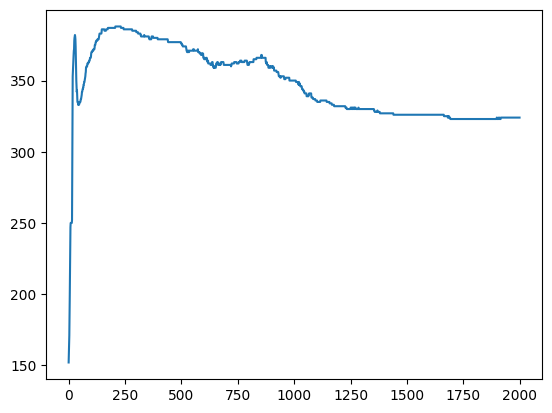

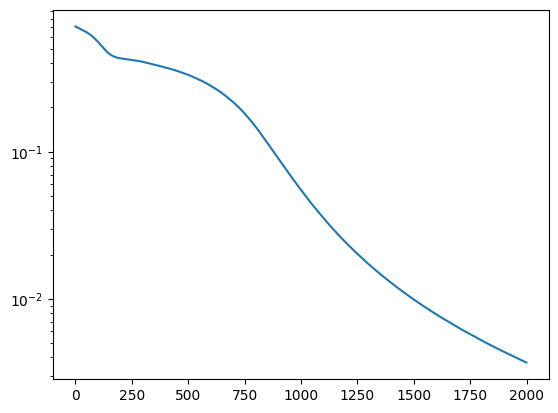

In [ ]:
#@title train network

EPOCHS = 2000

torch.manual_seed(1)
clf_network = classifier(num_classes=2)
clf_network.to(device)
optimizer = torch.optim.Adam(clf_network.parameters())
criterion = nn.CrossEntropyLoss()
loss_list, accuracy_list = [], []

for epoch in range(EPOCHS):

    clf_network.train()
    optimizer.zero_grad()

    y_hat = clf_network(x_tr_l)[0]
    # breakpoint()
    loss = criterion(y_hat, y_tr_l)
    loss.backward()
    loss_list.append(loss.item())


    with torch.no_grad():
      clf_network.eval()
      y_pred = clf_network(x_te)[0].argmax(1)
      accuracy = torch.sum((y_pred == y_te))
      accuracy_list.append(accuracy.item())


    optimizer.step()


plt.plot(accuracy_list)
plt.show()
plt.plot(loss_list)
plt.yscale('log')

In [ ]:
#@title train clustering_base_with K means

EPOCHS = 2000

torch.manual_seed(1)
num_classes = 10
clf_network = classifier(num_classes)
clf_network.to(device)
optimizer = torch.optim.Adam(clf_network.parameters())
criterion = nn.CrossEntropyLoss()
loss_list, accuracy_list = [], []

# Adjust output neurons to dimensions



input = x_tr_ul
for epoch in range(EPOCHS):

    clf_network.train()
    optimizer.zero_grad()

    # Calculate latent space with encoder and complete forward pass
    y_hat, latent = clf_network(input)
    # breakpoint()

    latent_nograd = latent.cpu().detach().numpy()

    # Generating pseudo labels with k means
    kmeans = KMeans(n_clusters=num_classes, n_init=num_classes)
    kmeans_model = kmeans.fit(latent_nograd)
    # y_pseudo = kmeans.predict(latent_nograd)
    y_pseudo = kmeans_model.labels_
    y_pseudo = torch.from_numpy(y_pseudo)
    y_pseudo = y_pseudo.long()

    # Calculate loss
    loss = criterion(y_hat, y_pseudo)
    loss.backward()
    loss_list.append(loss.item())


    optimizer.step()




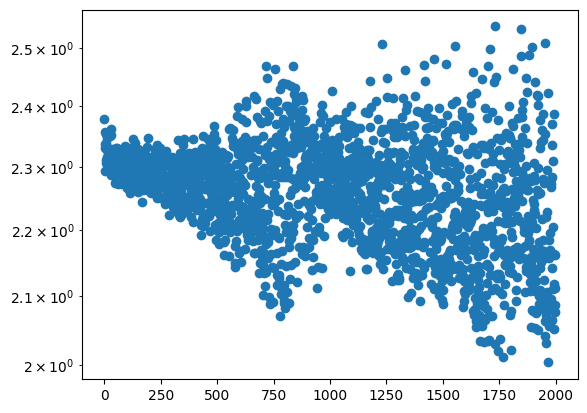

In [ ]:
plt.scatter(np.arange(len(loss_list)), loss_list)
plt.yscale('log')

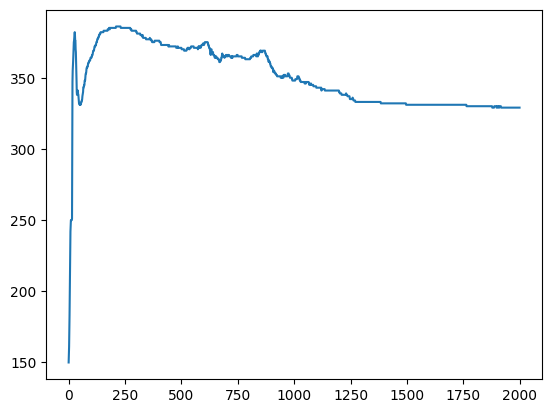

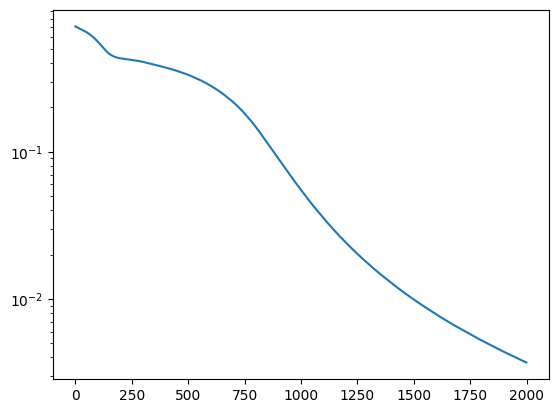

In [ ]:
torch.manual_seed(1)
clf_network = classifier(num_classes=2)
clf_network.to(device)
optimizer = torch.optim.Adam(clf_network.parameters())

loss_list, accuracy_list = [], []

for epoch in range(EPOCHS):

    clf_network.train()
    optimizer.zero_grad()

    y_hat = clf_network(x_tr_l)[0]
    # breakpoint()
    loss = criterion(y_hat, y_tr_l)
    loss.backward()
    loss_list.append(loss.item())


    with torch.no_grad():
      clf_network.eval()
      y_pred = clf_network(x_te)[0].argmax(1)
      accuracy = torch.sum((y_pred == y_te))
      accuracy_list.append(accuracy.item())


    optimizer.step()


plt.plot(accuracy_list)
plt.show()
plt.plot(loss_list)
plt.yscale('log')

In [ ]:
#@title train self supervized network

EPOCHS = 2000
noise_magnitude = 0.1

torch.manual_seed(1)




loss_list, accuracy_list = [], []


torch.manual_seed(1)
ss_model = ss_network()
ss_model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ss_model.parameters())
ss_loss = []

for epoch in range(EPOCHS):
    ss_model.train()
    optimizer.zero_grad()
    # Perturb
    x_tr_ul_perturbed = torch.randn_like(torch.randn_like(x_tr_ul)) * noise_magnitude + x_tr_ul
    reconst = ss_model(x_tr_ul_perturbed)[0]
    loss = criterion(reconst, x_tr_ul)
    loss.backward()
    ss_loss.append(loss.item())

#    with torch.no_grad():


    optimizer.step()


plt.plot(ss_loss)
plt.yscale('log')

NameError: ignored

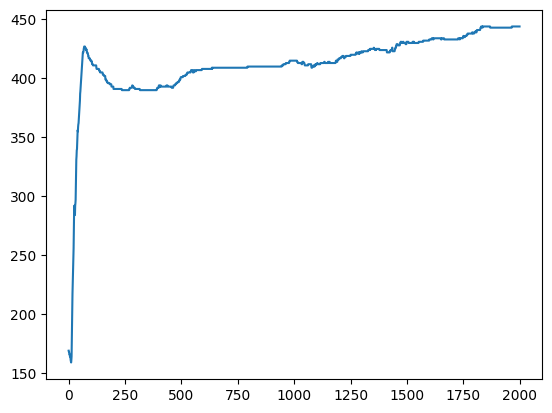

In [ ]:
#@title train supervised network

EPOCHS = 2000

torch.manual_seed(1)
clf_network = classifier()
clf_network.encoder.load_state_dict(ss_model.encoder.state_dict())
#clf_network import weights from pretrained model
optimizer = torch.optim.Adam(clf_network.parameters())
criterion = nn.CrossEntropyLoss()
loss_list, accuracy_list = [], []

for epoch in range(EPOCHS):

    clf_network.train()
    optimizer.zero_grad()

    y_hat = clf_network(x_tr_l)
    loss = criterion(y_hat, y_tr_l)
    loss.backward()
    loss_list.append(loss.item())

    with torch.no_grad():
      clf_network.eval()
      y_pred = clf_network(x_te).argmax(1)
      accuracy = torch.sum((y_pred == y_te))
      accuracy_list.append(accuracy.item())


    optimizer.step()


plt.plot(accuracy_list)

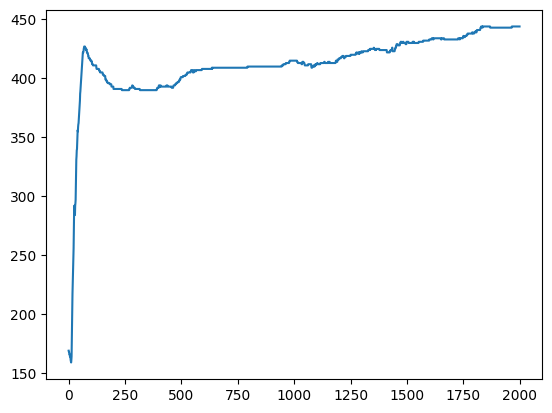

In [ ]:
#@title train supervised network

EPOCHS = 2000

torch.manual_seed(1)
clf_network = classifier()
clf_network.encoder.load_state_dict(ss_model.encoder.state_dict())
#clf_network import weights from pretrained model
optimizer = torch.optim.Adam(clf_network.parameters())
criterion = nn.CrossEntropyLoss()
loss_list, accuracy_list = [], []

for epoch in range(EPOCHS):

    clf_network.train()
    optimizer.zero_grad()

    y_hat = clf_network(x_tr_l)
    loss = criterion(y_hat, y_tr_l)
    loss.backward()
    loss_list.append(loss.item())

    with torch.no_grad():
      clf_network.eval()
      y_pred = clf_network(x_te).argmax(1)
      accuracy = torch.sum((y_pred == y_te))
      accuracy_list.append(accuracy.item())


    optimizer.step()


plt.plot(accuracy_list)

In [ ]:
torch.device('cuda')

NameError: ignored

In [ ]:
num_data_points = 20
magnitudes = np.linspace(0, 0.5, num_data_points)
max_accuracies = []
for noise_magnitude in magnitudes:

    acc = pretrain_and_train(x_tr_l, y_tr_l, x_tr_ul, y_tr_ul, x_te, y_te, ss_network,
                          clf_network, noise_magnitude)
    max_accuracies.append(acc)



In [ ]:
num_data_points = 20
magnitudes = np.linspace(0, 0.5, num_data_points)
device = 'cuda'
max_accuracies = []
for noise_magnitude in magnitudes:

    acc = pretrain_and_train(x_tr_l, y_tr_l, x_tr_ul, y_tr_ul, x_te, y_te, ss_network,
                          clf_network, noise_magnitude)
    max_accuracies.append(acc)

